# Perceptron - Classification of Diabetics
#!pip3 install torch

To predict if a person is likely to be diabetic or not

In [1]:
# Jupyter notebook commands
%config IPCompleter.greedy=True # enable intellisense by using 'tab' key

# Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import datasets

# Check for Cuda or CPU

In [3]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Additional Helper Functions

### Plotting Functions

In [4]:
class DataPlot():
    def __init__(self):
        plt.style.use('ggplot')        
        
    def plot_Size(self, width, height):
        self.fig=plt.figure(figsize=(width,height))            
        
    def xLim(self,xMin, xMax):
        plt.xlim(-2.0, 2.0)        
        
    def yLim(self,yMin, yMax):
        plt.ylim(yMin,yMax)        
    
    def plot_show(self):        
        plt.show()
        
    def plot_point(self,x,y,extra):
        plt.plot(x,y,extra)

    def plot_scatter(self, X, y, title):                    
        plt.title(title)        
        plt.xlabel("x1 - Age")
        plt.ylabel("x2 - Blood Sugar Levels",rotation=90)
        plt.scatter(X[y==0, 0], X[y==0, 1], c='g',label="Class 0 - No Diabetic") # plot all points where y == 0 (both col 0 and col 1 in X in Red)
        plt.scatter(X[y==1, 0], X[y==1, 1], c='r', label="Class 1 -Likely Diabetic") # plot all points where y == 0 (both col 0 and col 1 in X in Green)        
        plt.legend(loc="upper right")
        plt.xlim(-2.0, 2.0)
        plt.ylim(-2.0, 2.0)
        
    def plot_lineChart(self,X,y,title, x_label, y_label):
        plt.title(title)
        plt.plot(X,y)
        plt.xlabel(x_label)
        plt.ylabel(y_label,rotation=90)
              
    def plot_line2D(self,x1,y1,x2,y2):
        plt.plot([x1,x2],[y1,y2])
        
    def plot_fit2DLine(self, model):        
        w, b = model.get_params()
        b = b.item() # convert from tensor to float        
        w1,w2 = w.view(2) 
        w1 = w1.item()
        w2 = w2.item()
        
        # linear equation
        # w1x1 + w2x2 + b =0
        # w2x2 = -w1x1 - b = -(w1x1+b)
        # x2   = -(w1x1 + b)/w2 # equation of line in format, y=mx + c
        x1 = np.array([-2.0,2.0]) # this is the limits of this specific data plot
        x2 = -(w1 * x1 + b)/w2
        
        plt.plot(x1,x2,'b')
        
        #self.plot_line2D(x1,y1,x2,y2)        
        
        
    def plot_Decision_Boundary(self,model,X,y):        
        # to make the graph look nicer, we add extra space by adding '-1' to min() and '+1' to max(), 
        # else there is a empty space in the graph
        # empty border
        x_span = np.linspace(min(X[:,0])-1, max(X[:,0])+1)
        y_span = np.linspace(min(X[:,1])-1, max(X[:,1])+1)

        # https://stackoverflow.com/questions/36013063/what-is-the-purpose-of-meshgrid-in-python-numpy
        # both xx and yy are 2d arrays
        xx,yy = np.meshgrid(x_span, y_span)    
        # flatten the 2d arrays into 1d, then vertically concatenate into var grid
        #np.c_[xx.ravel(),yy.ravel()]
        grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()]).to(device)

        # predict the class of each point in the grid
        predictions = model.forward(grid)  
        
        # and reshape the prediction results so that they are linked to their
        # appropriate coordinate counterparts
        # use detach() to exclude any sub graphs from gradient computation
        # z contains the magnitute of the probablility and each corresponding coordinate
        z = predictions.view(xx.shape).detach().cpu().numpy()
        
        # use plt.contour, allows shape of our prediction data to be consistent with the
        # 50x50 shape of our graph such that each coordinate in the graph would be associated
        # with a corresponding prediction.
        # plot distinct contour zones, each of which represents a distinct probability level
        # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contourf.html
        plt.contourf(xx,yy,z)

# Data

### Create / Import Data


In [5]:
# instantiate Plotting helper functions
dataPlot = DataPlot()

# Make Blobs
# https://docs.w3cub.com/scikit_learn/modules/generated/sklearn.datasets.make_blobs/

n_pts = 100
centers = [ [-0.5,-0.5], [0.5, 0.5] ] 

# "Fake data" of people who have and did not have diabetics (for illustration only)
# X consists of 2 features: x1 - age and X2 - blood glucose levels
# y consists of either 1 or 0 (diabetic or not diabetic)
X, y = datasets.make_blobs(n_samples = n_pts,random_state=123, centers = centers, cluster_std = 0.5)

# Convert to Tensor
X_data = torch.Tensor(X).to(device)
y_data = torch.Tensor(y.reshape(y.shape[0], 1)).to(device)


print("X.shape is: {}".format(X.shape))
print("y.shape is: {}\n".format(y.shape))
print("X_data.shape is: {}".format(X_data.size()))
print("y_data.shape is: {}".format(y_data.size()))
print("\nFirst 10 rows of X are:")
print("x1 values,       x2 values")
print("=============,   =============")
print(X[0:10])
print("\nFirst 10 rows of y are: {}".format(y[0:10]))
print("set(y) returns: {}".format(set(y)))

X.shape is: (100, 2)
y.shape is: (100,)

X_data.shape is: torch.Size([100, 2])
y_data.shape is: torch.Size([100, 1])

First 10 rows of X are:
x1 values,       x2 values
=============,   =============
[[-0.0464474  -1.21434035]
 [ 0.8804747   0.66173442]
 [-0.62780969 -1.89929455]
 [ 0.58859616  0.485016  ]
 [ 0.13296813 -0.9333702 ]
 [-0.96791693  0.08791452]
 [ 0.1217814   0.66084329]
 [-0.66750538  0.01555723]
 [-0.47725496 -0.61654603]
 [ 0.37185611 -0.89903137]]

First 10 rows of y are: [0 1 0 1 0 0 1 0 0 0]
set(y) returns: {0, 1}


### Explore Data

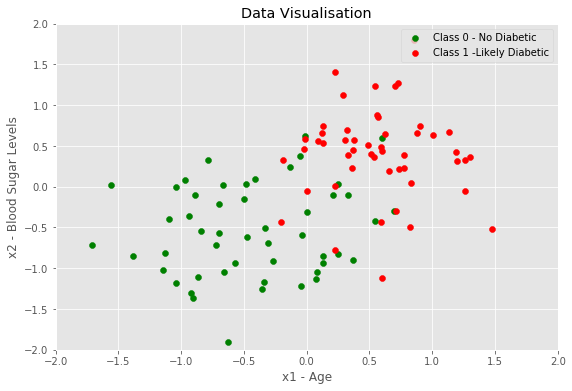

In [6]:
dataPlot.plot_Size(9,6)
dataPlot.plot_scatter(X,y,"Data Visualisation")

dataPlot.plot_show()

# Perceptron Class Definition - Classification
A perceptron only has 
* NO hidden layers
* One input layer
* One output layer

* Any number of input nodes in the input layer

<img src="Perceptron_Classification_tC.png" alt="Perceptron_Classification" width="600" height="300" align="left">

In [7]:
class Model(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()         
        self.linear_01 = nn.Linear(input_size, output_size)     
   
    def get_params(self):
        [w, b] = self.parameters()        
        return [w,b]
    
    def forward(self, x):        
        x = torch.sigmoid(self.linear_01(x)) # from input layer to the output layer
        # the output of the output layer is then used by .predict() to predict the class.
        return x    
        
    def train(self, epochs, updateRate, lr=0.01):
        print("starting training")
        
        # Binary Cross Entrophy
        self.criterion = nn.BCELoss() 
        
        # optimizer sgd = stochastic gradient descent
        self.optimizer = torch.optim.Adam(model.parameters(), lr) # model param and learning rate
        
        # We first compute the error of our model based on binay cross entropy criterion
        # then we take its derivative and by substracting the derivative from the weights and bias,
        # it updates them in the direction of the least error, descending with the gradient
        
        #epochs = epochs
        losses = []

        for i in range(epochs):                       
            y_pred = self.forward(X_data)
            loss = self.criterion(y_pred, y_data)   
            
            if(i%updateRate == 0): # print once every 50 epochs
                print("epoch:", i, "loss:", loss.item())            
            losses.append(loss.item())
                        
            self.optimizer.zero_grad() # set gradient back to 0 or it will accumulate
            loss.backward() 
            self.optimizer.step()   
        
        return losses
    
    def predict(self, x):
        prediction = []
        pred = self.forward(x)       
        
        # append the value from forward propagation
        prediction.append(pred.item()) 
        
        # append the prediction from the value
        if pred >= 0.5:
            prediction.append(1)            
        else:
            prediction.append(0)
        
        return prediction

# Instantiate Model

In [8]:
torch.manual_seed(50) # set random seed

# Input Layer - 2 neurons
# Output Layer - 1 neuron

model = Model(2, 1).to(device) # input_size, output_size

print(list(model.parameters()))
print()

print("After conversion to Numpy Array")
# to convert torch.size to a numpy array, the usual .numpy() doesn't work, need to .detach() first.
# also, I chose to flatten first using .view(w.numel), but depending on use case, this may not be needed.

w,b = model.parameters()
w = np.array(w.view(w.numel()).detach().cpu().numpy()) # need to do .cpu() 1st to take the tensor out of GPU
# otherwise,"can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.""

for i in range(len(w)):
    print('weight w{} = \b {:0.3f}'.format(i,w[i]))

print('bias b = \b {:0.3f}'.format(b.item())) # .item() to get a python float value



[Parameter containing:
tensor([[ 0.1669, -0.6100]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.1566], device='cuda:0', requires_grad=True)]

After conversion to Numpy Array
weight w0 =  0.167
weight w1 =  -0.610
bias b =  -0.157


### View Current Fit to Data

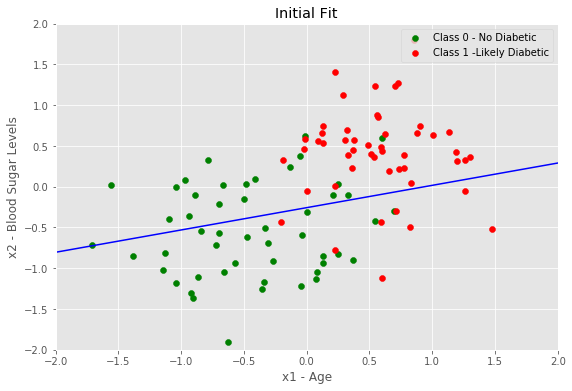

As we can see, the initial fit is not good at all.


In [9]:
dataPlot.plot_Size(9,6)
dataPlot.plot_scatter(X,y,"Initial Fit")

dataPlot.plot_fit2DLine(model)
dataPlot.plot_show()

print("As we can see, the initial fit is not good at all.")

# Train Model

In [10]:
epochs = 200
losses = model.train(epochs=epochs, updateRate=10, lr=0.1)

starting training
epoch: 0 loss: 0.815714418888092
epoch: 10 loss: 0.4296805262565613
epoch: 20 loss: 0.307425856590271
epoch: 30 loss: 0.27209511399269104
epoch: 40 loss: 0.26067739725112915
epoch: 50 loss: 0.25637832283973694
epoch: 60 loss: 0.2544349730014801
epoch: 70 loss: 0.25338730216026306
epoch: 80 loss: 0.2527470886707306
epoch: 90 loss: 0.2523295283317566
epoch: 100 loss: 0.2520504295825958
epoch: 110 loss: 0.2518630921840668
epoch: 120 loss: 0.251738041639328
epoch: 130 loss: 0.2516553997993469
epoch: 140 loss: 0.25160130858421326
epoch: 150 loss: 0.2515663802623749
epoch: 160 loss: 0.25154411792755127
epoch: 170 loss: 0.25153014063835144
epoch: 180 loss: 0.2515215575695038
epoch: 190 loss: 0.25151631236076355


# Plot Loss 

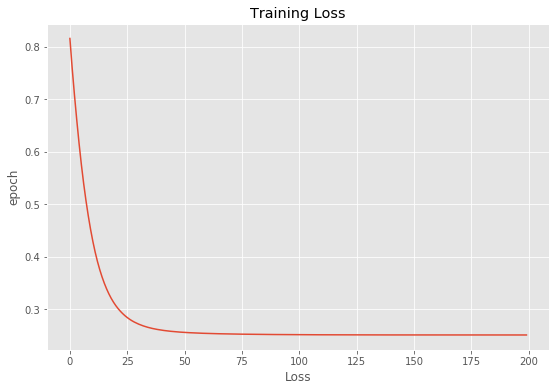

In [11]:
dataPlot.plot_Size(9,6)
dataPlot.plot_lineChart(range(epochs),losses,"Training Loss","Loss","epoch")
dataPlot.plot_show()


# Plot Fit

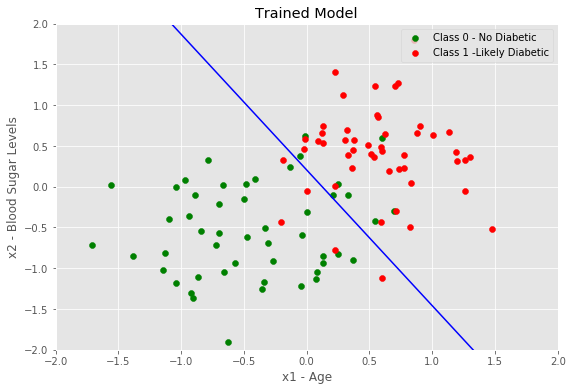

In [12]:
def plot_trained_model():
    dataPlot.plot_Size(9,6)
    dataPlot.plot_scatter(X,y,"Trained Model")

    dataPlot.plot_fit2DLine(model)   

plot_trained_model()
dataPlot.plot_show()

# Predict

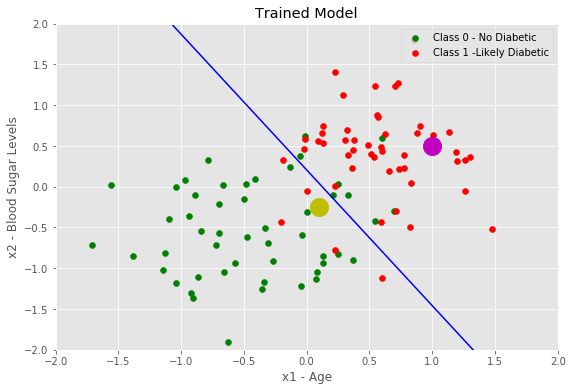

Decision rule: P(positive class)>0.5? class 1: class 0

Point 1 (magenta) -> p(positive class) = 0.99, Predicted class = 1.
point 2 (yellow ) -> p(positive class) = 0.34, Predicted class = 0.


In [13]:
# data points which we want to get a prediction
point1 = torch.Tensor([1.0, 0.5])
point2 = torch.Tensor([0.1, -0.25])

plot_trained_model() # plot the fitted model.

#extra = "'mo',markersize=14"
#dataPlot.plot_point(point1.numpy()[0], point1.numpy()[1],extra ) # markersize=14
#extra = "'yo',markersize=14"
#dataPlot.plot_point(point2.numpy()[0], point2.numpy()[1], extra)
plt.plot(point1.numpy()[0], point1.numpy()[1],'mo',markersize=18)
plt.plot(point2.numpy()[0], point2.numpy()[1], 'yo',markersize=18)

dataPlot.plot_show()


point01_pred = model.predict(torch.Tensor(point1).to(device))
point02_pred = model.predict(torch.Tensor(point2).to(device))

print("Decision rule: P(positive class)>0.5? class 1: class 0")
print("\nPoint 1 (magenta) -> p(positive class) = {:0.2f}, Predicted class = {}.".format(point01_pred[0],point01_pred[1]))
print("point 2 (yellow ) -> p(positive class) = {:0.2f}, Predicted class = {}.".format(point02_pred[0],point02_pred[1]))
